# Cifar-10 testset classification on Pynq

This notebook covers how to use low quantized neural networks on Pynq. 
It shows an example how CIFAR-10 testset can be inferred utilizing different precision neural networks inspired at VGG-16, featuring 6 convolutional layers, 3 max pool layers and 3 fully connected layers. There are 3 different precision available:

- CNVW1A1 using 1 bit weights and 1 bit activation,
- CNVW1A2 using 1 bit weights and 2 bit activation and
- CNVW2A2 using 2 bit weights and 2 bit activation

## 1. Import the package

In [1]:
import bnn

## 2. The Cifar-10 testset

This notebook required the testset from https://www.cs.toronto.edu/~kriz/cifar.html which contains 10000 images that can be processed by CNV network directly without preprocessing.

You can download the cifar-10 set from given url via wget and unzip it to a folder on Pynq as shown below.
This may take a while as the training set is included in the archive as well.
After that we need to read the labels from the binary file to be able to compare the results later:

In [2]:
#get
# !wget https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
#unzip
!tar -xf cifar-10-binary.tar.gz
labels = []
with open("/home/xilinx/jupyter_notebooks/bnn/cifar-10-batches-bin/test_batch.bin", "rb") as file:
    with open("/home/xilinx/jupyter_notebooks/bnn/cifar-10-batches-bin/10_test_batch.bin", "wb") as out_file:
        #for 10000 pictures
        for i in range(10000):
            #read first byte -> label
            label_read = file.read(1)
            labels.append(int.from_bytes(label_read, byteorder="big"))
            out_file.write(label_read)
            #read image (3072 bytes) and do nothing with it
            if i < 10:
                out_file.write(file.read(3072))
            else:
                file.read(3072)
        file.close()

## 3. Start inference

The inference can be performed with different precision for weights and activation. Creating a specific Classifier will automatically download the correct bitstream onto PL and load the weights and thresholds trained on the specific dataset. 

Thus that images are already Cifar-10 preformatted no preprocessing is required. Therefor the functions `classify_cifar` or `classify_cifars` can be used. When classifying non Cifar-10 formatted pictures refer to `classify_image` or `classify_images`  (see Notebook CNV-QNN_Cifar10).

### Case 1: 
#### W1A1 - 1 bit weight and 1 activation

Instantiate the classifier:

In [3]:
hw_classifier = bnn.CnvClassifier(bnn.NETWORK_CNVW1A1,'cifar10',bnn.RUNTIME_HW)

And start the inference on Cifar-10 preformatted multiple images:

In [4]:
result_W1A1 = hw_classifier.classify_cifars("/home/xilinx/jupyter_notebooks/bnn/cifar-10-batches-bin/test_batch.bin")
time_W1A1 = hw_classifier.usecPerImage

Inference took 3278692.93 microseconds, 327.87 usec per image
Classification rate: 3050.00 images per second


In [5]:
sw_classifier = bnn.CnvClassifier(bnn.NETWORK_CNVW1A1, 'cifar10', bnn.RUNTIME_SW)

In [6]:
result_W1A1_SW = sw_classifier.classify_cifars("/home/xilinx/jupyter_notebooks/bnn/cifar-10-batches-bin/10_test_batch.bin")
time_W1A1_SW = sw_classifier.usecPerImage

Inference took 20688833.75 microseconds, 1591448.75 usec per image
Classification rate: 0.63 images per second


### Case 2:
#### W1A2 - 1 bit weight and 2 activation

In [7]:
hw_classifier = bnn.CnvClassifier(bnn.NETWORK_CNVW1A2,'cifar10',bnn.RUNTIME_HW)

In [8]:
result_W1A2 = hw_classifier.classify_cifars("/home/xilinx/jupyter_notebooks/bnn/cifar-10-batches-bin/test_batch.bin")
time_W1A2 = hw_classifier.usecPerImage

Inference took 3278507.08 microseconds, 327.85 usec per image
Classification rate: 3050.17 images per second


In [9]:
sw_classifier = bnn.CnvClassifier(bnn.NETWORK_CNVW1A2, 'cifar10', bnn.RUNTIME_SW)

In [10]:
result_W1A1_SW = sw_classifier.classify_cifars("/home/xilinx/jupyter_notebooks/bnn/cifar-10-batches-bin/10_test_batch.bin")
time_W1A2_SW = sw_classifier.usecPerImage

Inference took 73518042.00 microseconds, 5655234.00 usec per image
Classification rate: 0.18 images per second


### Case 3:
#### W2A2 - 2 bit weight and 2 activation

In [11]:
hw_classifier = bnn.CnvClassifier(bnn.NETWORK_CNVW2A2,'cifar10',bnn.RUNTIME_HW)

In [12]:
result_W2A2 = hw_classifier.classify_cifars("/home/xilinx/jupyter_notebooks/bnn/cifar-10-batches-bin/test_batch.bin")
time_W2A2 = hw_classifier.usecPerImage

Inference took 11626534.42 microseconds, 1162.65 usec per image
Classification rate: 860.10 images per second


In [13]:
sw_classifier = bnn.CnvClassifier(bnn.NETWORK_CNVW2A2, 'cifar10', bnn.RUNTIME_SW)

In [14]:
result_W1A1_SW = sw_classifier.classify_cifars("/home/xilinx/jupyter_notebooks/bnn/cifar-10-batches-bin/10_test_batch.bin")
time_W2A2_SW = sw_classifier.usecPerImage

Inference took 123559501.00 microseconds, 9504577.00 usec per image
Classification rate: 0.11 images per second


## 4. Summary

### Inference time

Results can be visualized using `matplotlib`. Here the comparison of hardware execution time is plotted in microseconds per Image:

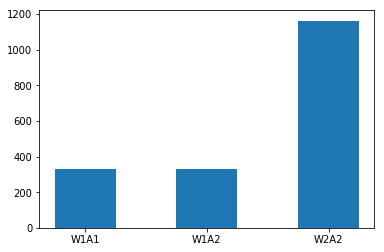

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

height = [time_W1A1, time_W1A2, time_W2A2]
bars   = ('W1A1', 'W1A2', 'W2A2')

y_pos=range(3)
plt.bar(y_pos, height, 0.5)
plt.xticks(y_pos, bars)

plt.show()

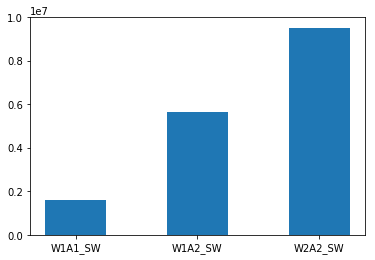

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

height = [time_W1A1_SW, time_W1A2_SW, time_W2A2_SW]
bars   = ('W1A1_SW', 'W1A2_SW', 'W2A2_SW')

y_pos=range(3)
plt.bar(y_pos, height, 0.5)
plt.xticks(y_pos, bars)

plt.show()

### Accuracy

The accuracy on the testset can be calculated by comparing the inferred labels against the one read at the beginning:


In [16]:
#compare against labels
countRight = 0
for idx in range(len(labels)):
    if labels[idx] == result_W1A1[idx]:
        countRight += 1
accuracyW1A1 = countRight*100/len(labels)

countRight = 0
for idx in range(len(labels)):
    if labels[idx] == result_W1A2[idx]:
        countRight += 1
accuracyW1A2 = countRight*100/len(labels)

countRight = 0
for idx in range(len(labels)):
    if labels[idx] == result_W2A2[idx]:
        countRight += 1
accuracyW2A2 = countRight*100/len(labels)

print("Accuracy W1A1: ",accuracyW1A1,"%")
print("Accuracy W1A2: ",accuracyW1A2,"%")
print("Accuracy W2A2: ",accuracyW2A2,"%")

Accuracy W1A1:  79.22 %
Accuracy W1A2:  82.66 %
Accuracy W2A2:  84.29 %


## 6. Reset the device

In [17]:
from pynq import Xlnk

xlnk = Xlnk()
xlnk.xlnk_reset()